In [94]:
# import dependencies
from splinter import Browser
from bs4 import BeautifulSoup as soup
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import matplotlib.pyplot as plt 

In [95]:
# set up Splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)

[WDM] - Downloading: 100%|█████████████████| 8.41M/8.41M [00:00<00:00, 27.4MB/s]


In [96]:
# access Mars Temperature website
url = 'https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html'
browser.visit(url)


In [97]:
# option 1: scrape data with Pandas
df = pd.read_html('https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html')
df

[        id terrestrial_date   sol   ls  month  min_temp  pressure
 0        2       2012-08-16    10  155      6     -75.0     739.0
 1       13       2012-08-17    11  156      6     -76.0     740.0
 2       24       2012-08-18    12  156      6     -76.0     741.0
 3       35       2012-08-19    13  157      6     -74.0     732.0
 4       46       2012-08-20    14  157      6     -74.0     740.0
 ...    ...              ...   ...  ...    ...       ...       ...
 1862  1889       2018-02-23  1973  133      5     -78.0     730.0
 1863  1892       2018-02-24  1974  134      5     -77.0     729.0
 1864  1894       2018-02-25  1975  134      5     -76.0     729.0
 1865  1893       2018-02-26  1976  135      5     -77.0     728.0
 1866  1895       2018-02-27  1977  135      5     -77.0     727.0
 
 [1867 rows x 7 columns]]

In [98]:
# option 2: scrape data with Splinter and BeautifulSoup

html = browser.html
temp_soup = soup(html, 'html.parser')

# find table
tabula = temp_soup.find('tbody')
# print(tabula)

In [99]:
# store table data in Py

# First, use DevTools to discover whether the table
# contains usable classes. 
# Second, use the Beautiful Soup find_all method to 
# extract all the rows with a line of code. 
# Third, find and extract the data from each cell in a 
# specified row, and store the data from each row 
# in a Python list. Fourth, use a for loop 
# to add the data from each row to a list that 
# will contain the data from all the rows.
list_rows = []

headings = tabula.find_all('th')

heading_list = []
for heading in headings:
    heading_list.append(heading.text)
print(heading_list)
    
rows = tabula.find_all('tr', class_ = 'data-row')

for row in rows:
    rowlette = []
    rowlette.append(row.text.strip().replace("\n", ", "))
    list_rows.append(rowlette)
    
# print(list_rows)



['id', 'terrestrial_date', 'sol', 'ls', 'month', 'min_temp', 'pressure']


In [100]:
# Assemble scraped data in a pd DF

import json

mars_df = pd.DataFrame(list_rows, columns = ['all_data'])

all_cols = pd.concat([mars_df['all_data'].str.split(', ', expand=True)], axis=1)
renamed = all_cols.rename(columns={0: 'id', 1: 'terrestrial_date', 2: 'sol', 3: 'ls', 4: 'month', 5: 'min_temp', 6: 'pressure'})
renamed

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
1,13,2012-08-17,11,156,6,-76.0,740.0
2,24,2012-08-18,12,156,6,-76.0,741.0
3,35,2012-08-19,13,157,6,-74.0,732.0
4,46,2012-08-20,14,157,6,-74.0,740.0
...,...,...,...,...,...,...,...
1862,1889,2018-02-23,1973,133,5,-78.0,730.0
1863,1892,2018-02-24,1974,134,5,-77.0,729.0
1864,1894,2018-02-25,1975,134,5,-76.0,729.0
1865,1893,2018-02-26,1976,135,5,-77.0,728.0


In [147]:
renamed.dtypes

id                           int64
terrestrial_date    datetime64[ns]
sol                          int64
ls                           int64
month                        int64
min_temp                   float64
pressure                   float64
dtype: object

In [148]:
# Recast data types
renamed['id'] = pd.to_numeric(renamed['id'])
renamed['terrestrial_date'] = pd.to_datetime(renamed['terrestrial_date'])
renamed['sol'] = pd.to_numeric(renamed['sol'])
renamed['ls']= pd.to_numeric(renamed['ls'])
renamed['month']= pd.to_numeric(renamed['month'])
renamed['min_temp'] = pd.to_numeric(renamed['min_temp'])
renamed['pressure'] = pd.to_numeric(renamed['pressure'])


In [149]:
# How many months exist on Mars?
renamed['month'].describe()

# Answer: 12 (max for 'month' column)

count    1867.000000
mean        6.141939
std         3.506493
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        12.000000
Name: month, dtype: float64

Text(0.5, 1.0, 'Temperature on Mars by Month')

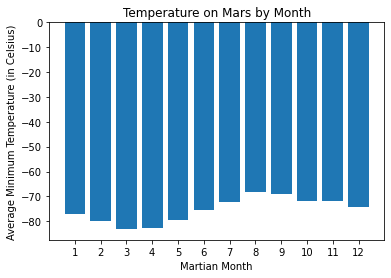

In [150]:
# What are the coldest and the warmest months on Mars (at the location of Curiosity)? 
# Get the answer by averaging the minimum daily temperature of all the months. 
# Plot the results as a bar chart.
import numpy as np


grouped_data = renamed.groupby('month')
temp_data = grouped_data['min_temp'].mean()

x_axis = np.arange(1,13)

plt.bar(x_axis, temp_data)
plt.xticks(np.arange (1, 13, step = 1.0))
plt.xlabel('Martian Month')
plt.ylabel('Average Minimum Temperature (in Celsius)')
plt.title('Temperature on Mars by Month')
# Answer: On Mars, the coldest month is Month 3, and the warmest month is Month 8. 

Text(0.5, 1.0, 'Atmospheric Pressure on Mars by Month')

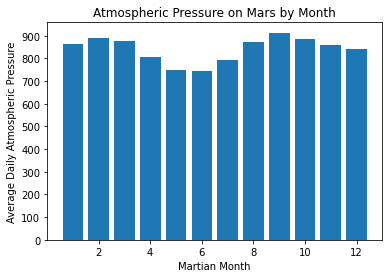

In [151]:
# Which months have the lowest and the highest atmospheric pressure on Mars? 
# Get the answer by averaging the daily atmospheric pressure of all the months. 
# Plot the results as a bar chart.

pressure_data = grouped_data['pressure'].mean()
x_axis = np.arange(1,13)
plt.bar(x_axis, pressure_data)
plt.yticks(np.arange (0, 1000, step = 100.0))
plt.xlabel('Martian Month')
plt.ylabel('Average Daily Atmospheric Pressure')
plt.title('Atmospheric Pressure on Mars by Month')

# Answer: On Mars, the lowest atmospheric pressures are in Month 6, and the highest atmospheric pressures are in Month 9

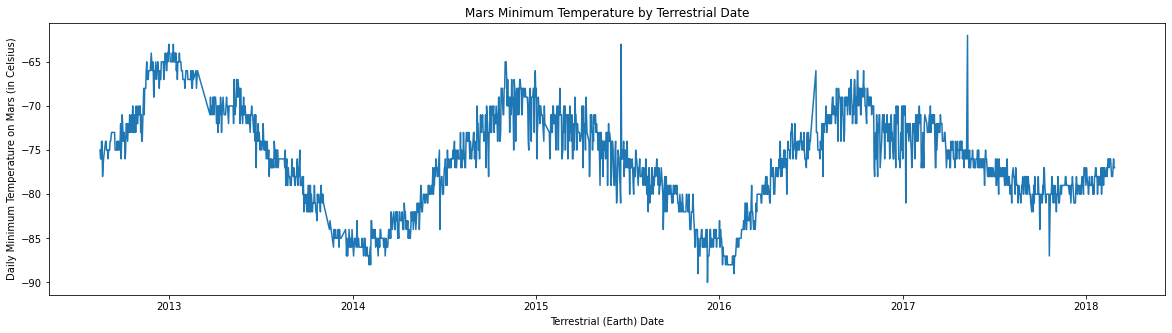

In [152]:
# About how many terrestrial (Earth) days exist in a Martian year? 
# That is, in the time that Mars circles the Sun once, how many days elapse on Earth? 
# Visually estimate the result by plotting the daily minimum temperature.

x_axis = renamed['terrestrial_date']
y_axis = renamed['min_temp']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.plot(x_axis, y_axis)
plt.xlabel('Terrestrial (Earth) Date')
plt.ylabel('Daily Minimum Temperature on Mars (in Celsius)')
plt.title('Mars Minimum Temperature by Terrestrial Date')
plt.show()



In [153]:
# Export to a csv file

In [154]:
browser.quit()